#**Практическое задание №1**

Установка необходимых пакетов:

In [1]:
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown

Монтирование Вашего Google Drive к текущему окружению:

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Константы, которые пригодятся в коде далее, и ссылки (gdrive идентификаторы) на предоставляемые наборы данных:

In [4]:
EVALUATE_ONLY = False
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = {
    'train_big': '1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi',
    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
    'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui',
    'test_big': '1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr',
    'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',
    'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc'
}

Импорт необходимых зависимостей:

In [56]:
from pathlib import Path
import numpy as np
from typing import List
from tqdm import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score
import gdown
from torchvision import models
import torch.nn as nn
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import matplotlib.colors as colors


---
### Класс Dataset

Предназначен для работы с наборами данных, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [6]:
class Dataset:

    def __init__(self, name):
        self.name = name
        self.is_loaded = False
        url = f"https://drive.google.com/uc?export=download&confirm=pbef&id={DATASETS_LINKS[name]}"
        output = f'{name}.npz'
        if os.path.exists(output):
            print(f"Файл {output} уже существует — пропускаю скачивание.")
        else:
            print(f"Скачивание {output} с Google Drive...")
            gdown.download(url, output, quiet=False)
        print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(f'{name}.npz')
        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]

    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

### Пример использвания класса Dataset
Загрузим обучающий набор данных, получим произвольное изображение с меткой. После чего визуализируем изображение, выведем метку. В будущем, этот кусок кода можно закомментировать или убрать.

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui
To: /home/avgurmordra/Desktop/MSU3/MMOI/1-task/train_tiny.npz
100%|██████████| 105M/105M [01:00<00:00, 1.73MB/s] 


Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.

Got numpy array of shape (224, 224, 3), and label with code 7.
Label code corresponds to STR class.


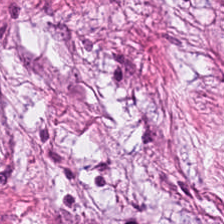

In [10]:
d_train_tiny = Dataset('train_tiny')

img, lbl = d_train_tiny.random_image_with_label()
print()
print(f'Got numpy array of shape {img.shape}, and label with code {lbl}.')
print(f'Label code corresponds to {TISSUE_CLASSES[lbl]} class.')

pil_img = Image.fromarray(img)
IPython.display.display(pil_img)

### Обёртка над Dataset для использования с PyTorch

In [7]:
# ============================================================
# (Опционально) Обёртка над Dataset для использования с PyTorch
# ============================================================

# ВНИМАНИЕ:
# Этот код нужен только тем, кто хочет решать задание с помощью PyTorch.
# Он показывает, как "подключить" наш Dataset к torch.utils.data.DataLoader.

try:
    import torch
    from torch.utils.data import Dataset as TorchDataset, DataLoader
    import torchvision.transforms as T
    from PIL import Image

    class HistologyTorchDataset(TorchDataset):
        """
        Обёртка над Dataset для использования с PyTorch.

        base_dataset: экземпляр Dataset('train'), Dataset('train_small'), etc.
        transform:    функция/объект, преобразующий изображение (PIL.Image -> torch.Tensor).

        """
        def __init__(self, base_dataset, augment = True):
            self.base = base_dataset
            self.augment = augment
            self.aug_transform = T.Compose([
                T.RandomHorizontalFlip(p=0.5),
                T.RandomVerticalFlip(p=0.5),
                T.RandomRotation(degrees=90),
                T.ColorJitter(
                    brightness=0.3,
                    contrast=0.3,
                    saturation=0.3,
                    hue=0.02
                )
            ]) if augment else None
            # Минимальный transform по умолчанию:
            # np.uint8 [0, 255] -> float32 [0.0, 1.0]
            self.normalization = T.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
            self.transform  = T.Compose([
                T.ToTensor(),
                self.normalization,
            ])

        def __len__(self):
            # Размер датасета
            return len(self.base.images)

        def __getitem__(self, idx):
            """
            Возвращает (image_tensor, label) для PyTorch.
            image_tensor: torch.Tensor формы [3, H, W]
            label: int
            """
            img, label = self.base.image_with_label(idx)  # img: np.ndarray (H, W, 3)
            img = Image.fromarray(img)                    # в PIL.Image
            if self.augment:
                img = self.aug_transform(img)
            img = self.transform(img)                     # в torch.Tensor
            return img, label

except ImportError:
    HistologyTorchDataset = None
    print("PyTorch / torchvision не найдены. Обёртка HistologyTorchDataset недоступна.")

### Пример использвания класса HistologyTorchDataset

In [13]:
if "HistologyTorchDataset" not in globals() or HistologyTorchDataset is None:
    print("PyTorch не установлен или обёртка недоступна — пример пропущен.")
else:
    print("Пример использования PyTorch-обёртки над Dataset")

    base_train = Dataset('train_tiny')

    # Создаём PyTorch-совместимый датасет
    train_ds = HistologyTorchDataset(base_train)

    # DataLoader автоматически создаёт батчи и перемешивает данные
    from torch.utils.data import DataLoader
    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)

    # Берём один батч и выводим информацию
    images_batch, labels_batch = next(iter(train_loader))

    print("Форма батча изображений:", tuple(images_batch.shape))  # [batch, 3, 224, 224]
    print("Форма батча меток:", tuple(labels_batch.shape))        # [batch]
    print("Пример меток:", labels_batch[:10].tolist())

    print("Тип images_batch:", type(images_batch))
    print("Тип labels_batch:", type(labels_batch))


Пример использования PyTorch-обёртки над Dataset


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui
To: /home/avgurmordra/Desktop/MSU3/MMOI/1-task/train_tiny.npz
100%|██████████| 105M/105M [01:05<00:00, 1.61MB/s] 


Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.
Форма батча изображений: (8, 3, 224, 224)
Форма батча меток: (8,)
Пример меток: [2, 1, 7, 3, 3, 0, 0, 6]
Тип images_batch: <class 'torch.Tensor'>
Тип labels_batch: <class 'torch.Tensor'>


---
### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [8]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

---
### Решение 

In [60]:
class Model:

    def __init__(self, num_classes = 9, studying_try = "1"):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        torch.cuda.empty_cache()
        print(self.device)
        self.model = models.efficientnet_b0(
            weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1
        )
        in_ch = self.model.classifier[1].in_features
        self.model.classifier[1] = nn.Linear(in_ch, num_classes)

        self.model = self.model.to(self.device)

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=3e-4)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=10)

        self.studying_try = studying_try

        self.test_transform = T.Compose([
            T.ToTensor(),
            T.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

        self.train_loss_history = []
        self.test_accuracy_history = []
        self.test_balanced_accuracy_history = []



    def save(self, name):
        path = f"models/{name}_{self.studying_try}.pt"
        torch.save(self.model.state_dict(), path)
        print(f"Модель сохранена локально: {path}")

    def load(self, link):
        save_path = "model_weights.pt"
        gdown.download(link, save_path, quiet = False)
        self.model.load_state_dict(torch.load(save_path, map_location=self.device))



    def train(self, train_dataset: Dataset, test_dataset: Dataset, batch_size = 32, epochs = 30):
        histology_dataset = HistologyTorchDataset(train_dataset, augment = True)
        loader = torch.utils.data.DataLoader(
            histology_dataset,
            batch_size = batch_size,
            shuffle = True,
            num_workers = 2
        )

        for epoch in range(epochs):
            self.model.train()
            epoch_loss = 0

            pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}",dynamic_ncols = True)
            for imgs, labels in pbar:
                imgs = imgs.to(self.device)
                labels = torch.tensor(labels).to(self.device)

                self.optimizer.zero_grad()
                preds = self.model(imgs)
                loss = self.criterion(preds, labels)
                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item()
                pbar.set_postfix(loss=f"{loss.item():.4f}")

            self.scheduler.step()
            mean_loss = epoch_loss / len(loader)
            self.train_loss_history.append(mean_loss)
            print(f"Epoch {epoch+1} done. Loss={mean_loss:.4f}")
            acc = self.calculate_metrics_on_train(test_dataset=test_dataset)
            self.save(f"{epoch}_{acc:.4f}")
            print("Модель сохранена")        

    def test_on_dataset(self, dataset: Dataset, limit=None):
        predictions = []
        n = dataset.n_files if not limit else int(dataset.n_files * limit)
        for img in tqdm(dataset.images_seq(n), total=n):
            predictions.append(self.test_on_image(img))
        return predictions

    def test_on_image(self, img: np.ndarray):
        self.model.eval()

        img = self.test_transform(img).unsqueeze(0).to(self.device)

        with torch.no_grad():
            probs = self.model(img)
            pred = torch.argmax(probs, dim=1).item()

        return pred
    
    def calculate_metrics_on_train(self, test_dataset: Dataset):
        print("Test on test dataset")
        preds = self.test_on_dataset(test_dataset)
        gt = list(test_dataset.labels[:len(preds)])
        Metrics.print_all(gt, preds, info = f"testing")
        acc = Metrics.accuracy(gt,preds)
        bacc = Metrics.accuracy(gt, preds)
        self.test_accuracy_history.append(acc)
        self.test_balanced_accuracy_history.append(bacc)
        return acc, bacc
        
    def plot_training_history(self):
        
        epochs = range(1, len(self.train_loss_history) + 1)

        plt.figure(figsize=(14,5))

        # ---- LOSS ----
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_loss_history, marker='o')
        plt.title("Training Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)

        # ---- ACCURACY ----
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.test_accuracy_history, marker='o', label="Accuracy")
        plt.plot(epochs, self.test_balanced_accuracy_history, marker='o', label="Balanced Accuracy")
        plt.title("Test Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.grid(True)
        plt.legend()

        plt.show()
        
    def plot_matrix(self, test_dataset: Dataset):
        preds = self.test_on_dataset(test_dataset)
        gt = list(test_dataset.labels[:len(preds)])
        cm = confusion_matrix(gt, preds)
        plt.figure(figsize=(10, 8))
        plt.imshow(cm, cmap="Blues", norm=colors.LogNorm())
        plt.title("Confusion Matrix")
        plt.colorbar()
        

Файл train_big.npz уже существует — пропускаю скачивание.
Loading dataset train_big from npz.
Done. Dataset train_big consists of 18000 images.
Файл test_big.npz уже существует — пропускаю скачивание.
Loading dataset test_big from npz.
Done. Dataset test_big consists of 4500 images.
cuda


Epoch 1/40:   0%|          | 0/360 [00:00<?, ?it/s]/tmp/ipykernel_4641/1396217602.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(self.device)
Epoch 1/40: 100%|██████████| 360/360 [01:26<00:00,  4.16it/s, loss=0.1574]


Epoch 1 done. Loss=0.2808
Test on test dataset


100%|██████████| 4500/4500 [00:39<00:00, 114.44it/s]


metrics for testing:
	 accuracy 0.9693:
	 balanced accuracy 0.9693:
Модель сохранена локально: models/0_0.9693_1B0_big.pt
Модель сохранена


Epoch 2/40:   0%|          | 0/360 [00:00<?, ?it/s]/tmp/ipykernel_4641/1396217602.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(self.device)
Epoch 2/40: 100%|██████████| 360/360 [01:23<00:00,  4.33it/s, loss=0.0295]


Epoch 2 done. Loss=0.1118
Test on test dataset


100%|██████████| 4500/4500 [00:38<00:00, 115.57it/s]


metrics for testing:
	 accuracy 0.9811:
	 balanced accuracy 0.9811:
Модель сохранена локально: models/1_0.9811_1B0_big.pt
Модель сохранена


Epoch 3/40:   0%|          | 0/360 [00:00<?, ?it/s]/tmp/ipykernel_4641/1396217602.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(self.device)
Epoch 3/40: 100%|██████████| 360/360 [01:25<00:00,  4.22it/s, loss=0.0163]


Epoch 3 done. Loss=0.0805
Test on test dataset


100%|██████████| 4500/4500 [00:39<00:00, 114.82it/s]


metrics for testing:
	 accuracy 0.9867:
	 balanced accuracy 0.9867:
Модель сохранена локально: models/2_0.9867_1B0_big.pt
Модель сохранена


Epoch 4/40:   0%|          | 0/360 [00:00<?, ?it/s]/tmp/ipykernel_4641/1396217602.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(self.device)
Epoch 4/40: 100%|██████████| 360/360 [01:27<00:00,  4.10it/s, loss=0.0273]


Epoch 4 done. Loss=0.0645
Test on test dataset


100%|██████████| 4500/4500 [00:37<00:00, 118.92it/s]


metrics for testing:
	 accuracy 0.9873:
	 balanced accuracy 0.9873:
Модель сохранена локально: models/3_0.9873_1B0_big.pt
Модель сохранена


Epoch 5/40:   0%|          | 0/360 [00:00<?, ?it/s]/tmp/ipykernel_4641/1396217602.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(self.device)
Epoch 5/40: 100%|██████████| 360/360 [01:24<00:00,  4.25it/s, loss=0.0621]


Epoch 5 done. Loss=0.0497
Test on test dataset


100%|██████████| 4500/4500 [00:37<00:00, 120.60it/s]


metrics for testing:
	 accuracy 0.9887:
	 balanced accuracy 0.9887:
Модель сохранена локально: models/4_0.9887_1B0_big.pt
Модель сохранена


Epoch 6/40:   0%|          | 0/360 [00:00<?, ?it/s]/tmp/ipykernel_4641/1396217602.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(self.device)
Epoch 6/40: 100%|██████████| 360/360 [01:23<00:00,  4.32it/s, loss=0.0310]


Epoch 6 done. Loss=0.0379
Test on test dataset


100%|██████████| 4500/4500 [00:37<00:00, 119.48it/s]


metrics for testing:
	 accuracy 0.9911:
	 balanced accuracy 0.9911:
Модель сохранена локально: models/5_0.9911_1B0_big.pt
Модель сохранена


Epoch 7/40:   0%|          | 0/360 [00:00<?, ?it/s]/tmp/ipykernel_4641/1396217602.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(self.device)
Epoch 7/40: 100%|██████████| 360/360 [01:22<00:00,  4.37it/s, loss=0.0026]


Epoch 7 done. Loss=0.0279
Test on test dataset


100%|██████████| 4500/4500 [00:38<00:00, 117.10it/s]


metrics for testing:
	 accuracy 0.9922:
	 balanced accuracy 0.9922:
Модель сохранена локально: models/6_0.9922_1B0_big.pt
Модель сохранена


Epoch 8/40:   0%|          | 0/360 [00:00<?, ?it/s]/tmp/ipykernel_4641/1396217602.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(self.device)
Epoch 8/40: 100%|██████████| 360/360 [01:21<00:00,  4.42it/s, loss=0.0018]


Epoch 8 done. Loss=0.0238
Test on test dataset


100%|██████████| 4500/4500 [00:37<00:00, 120.37it/s]


metrics for testing:
	 accuracy 0.9913:
	 balanced accuracy 0.9913:
Модель сохранена локально: models/7_0.9913_1B0_big.pt
Модель сохранена


Epoch 9/40:   0%|          | 0/360 [00:00<?, ?it/s]/tmp/ipykernel_4641/1396217602.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(self.device)
Epoch 9/40: 100%|██████████| 360/360 [01:21<00:00,  4.40it/s, loss=0.0266]


Epoch 9 done. Loss=0.0182
Test on test dataset


100%|██████████| 4500/4500 [00:36<00:00, 121.73it/s]


metrics for testing:
	 accuracy 0.9918:
	 balanced accuracy 0.9918:
Модель сохранена локально: models/8_0.9918_1B0_big.pt
Модель сохранена


Epoch 10/40:   0%|          | 0/360 [00:00<?, ?it/s]/tmp/ipykernel_4641/1396217602.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(self.device)
Epoch 10/40: 100%|██████████| 360/360 [01:19<00:00,  4.53it/s, loss=0.0047]


Epoch 10 done. Loss=0.0151
Test on test dataset


100%|██████████| 4500/4500 [00:37<00:00, 121.02it/s]


metrics for testing:
	 accuracy 0.9920:
	 balanced accuracy 0.9920:
Модель сохранена локально: models/9_0.9920_1B0_big.pt
Модель сохранена


Epoch 11/40:   0%|          | 0/360 [00:00<?, ?it/s]/tmp/ipykernel_4641/1396217602.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(self.device)
Epoch 11/40: 100%|██████████| 360/360 [01:24<00:00,  4.28it/s, loss=0.0851]


Epoch 11 done. Loss=0.0153
Test on test dataset


100%|██████████| 4500/4500 [00:37<00:00, 121.44it/s]


metrics for testing:
	 accuracy 0.9916:
	 balanced accuracy 0.9916:
Модель сохранена локально: models/10_0.9916_1B0_big.pt
Модель сохранена


Epoch 12/40:   0%|          | 0/360 [00:00<?, ?it/s]/tmp/ipykernel_4641/1396217602.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(self.device)
Epoch 12/40: 100%|██████████| 360/360 [01:17<00:00,  4.67it/s, loss=0.0287]


Epoch 12 done. Loss=0.0153
Test on test dataset


100%|██████████| 4500/4500 [00:37<00:00, 120.67it/s]


metrics for testing:
	 accuracy 0.9924:
	 balanced accuracy 0.9924:
Модель сохранена локально: models/11_0.9924_1B0_big.pt
Модель сохранена


Epoch 13/40:   0%|          | 0/360 [00:00<?, ?it/s]/tmp/ipykernel_4641/1396217602.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(self.device)
Epoch 13/40: 100%|██████████| 360/360 [01:15<00:00,  4.77it/s, loss=0.0169]


Epoch 13 done. Loss=0.0160
Test on test dataset


100%|██████████| 4500/4500 [00:36<00:00, 122.05it/s]


metrics for testing:
	 accuracy 0.9931:
	 balanced accuracy 0.9931:
Модель сохранена локально: models/12_0.9931_1B0_big.pt
Модель сохранена


Epoch 14/40:   0%|          | 0/360 [00:00<?, ?it/s]/tmp/ipykernel_4641/1396217602.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(self.device)
Epoch 14/40: 100%|██████████| 360/360 [01:16<00:00,  4.73it/s, loss=0.1499]


Epoch 14 done. Loss=0.0179
Test on test dataset


100%|██████████| 4500/4500 [00:36<00:00, 124.65it/s]


metrics for testing:
	 accuracy 0.9913:
	 balanced accuracy 0.9913:
Модель сохранена локально: models/13_0.9913_1B0_big.pt
Модель сохранена


Epoch 15/40:   0%|          | 0/360 [00:00<?, ?it/s]/tmp/ipykernel_4641/1396217602.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(self.device)
Epoch 15/40: 100%|██████████| 360/360 [01:16<00:00,  4.72it/s, loss=0.0148]


Epoch 15 done. Loss=0.0237
Test on test dataset


100%|██████████| 4500/4500 [00:36<00:00, 123.40it/s]


metrics for testing:
	 accuracy 0.9907:
	 balanced accuracy 0.9907:
Модель сохранена локально: models/14_0.9907_1B0_big.pt
Модель сохранена


Epoch 16/40:   0%|          | 0/360 [00:00<?, ?it/s]/tmp/ipykernel_4641/1396217602.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(self.device)
Epoch 16/40: 100%|██████████| 360/360 [01:15<00:00,  4.74it/s, loss=0.1286]


Epoch 16 done. Loss=0.0287
Test on test dataset


100%|██████████| 4500/4500 [00:35<00:00, 127.58it/s]


metrics for testing:
	 accuracy 0.9911:
	 balanced accuracy 0.9911:
Модель сохранена локально: models/15_0.9911_1B0_big.pt
Модель сохранена


Epoch 17/40:   0%|          | 0/360 [00:00<?, ?it/s]/tmp/ipykernel_4641/1396217602.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(self.device)
Epoch 17/40: 100%|██████████| 360/360 [01:15<00:00,  4.77it/s, loss=0.0048]


Epoch 17 done. Loss=0.0376
Test on test dataset


100%|██████████| 4500/4500 [00:35<00:00, 126.15it/s]


metrics for testing:
	 accuracy 0.9807:
	 balanced accuracy 0.9807:
Модель сохранена локально: models/16_0.9807_1B0_big.pt
Модель сохранена


Epoch 18/40:   0%|          | 0/360 [00:00<?, ?it/s]/tmp/ipykernel_4641/1396217602.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(self.device)
Epoch 18/40: 100%|██████████| 360/360 [01:37<00:00,  3.70it/s, loss=0.0564]


Epoch 18 done. Loss=0.0388
Test on test dataset


100%|██████████| 4500/4500 [00:42<00:00, 105.70it/s]


metrics for testing:
	 accuracy 0.9902:
	 balanced accuracy 0.9902:
Модель сохранена локально: models/17_0.9902_1B0_big.pt
Модель сохранена


Epoch 19/40:   0%|          | 0/360 [00:00<?, ?it/s]/tmp/ipykernel_4641/1396217602.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(self.device)
Epoch 19/40: 100%|██████████| 360/360 [01:24<00:00,  4.28it/s, loss=0.0209]


Epoch 19 done. Loss=0.0405
Test on test dataset


100%|██████████| 4500/4500 [00:37<00:00, 120.26it/s]


metrics for testing:
	 accuracy 0.9856:
	 balanced accuracy 0.9856:
Модель сохранена локально: models/18_0.9856_1B0_big.pt
Модель сохранена


Epoch 20/40:   0%|          | 0/360 [00:00<?, ?it/s]/tmp/ipykernel_4641/1396217602.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(self.device)
Epoch 20/40: 100%|██████████| 360/360 [01:17<00:00,  4.62it/s, loss=0.0135]


Epoch 20 done. Loss=0.0392
Test on test dataset


100%|██████████| 4500/4500 [00:36<00:00, 123.06it/s]


metrics for testing:
	 accuracy 0.9902:
	 balanced accuracy 0.9902:
Модель сохранена локально: models/19_0.9902_1B0_big.pt
Модель сохранена


Epoch 21/40:   0%|          | 0/360 [00:00<?, ?it/s]/tmp/ipykernel_4641/1396217602.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(self.device)
Epoch 21/40: 100%|██████████| 360/360 [01:17<00:00,  4.65it/s, loss=0.0406]


Epoch 21 done. Loss=0.0353
Test on test dataset


100%|██████████| 4500/4500 [00:36<00:00, 124.17it/s]


metrics for testing:
	 accuracy 0.9882:
	 balanced accuracy 0.9882:
Модель сохранена локально: models/20_0.9882_1B0_big.pt
Модель сохранена


Epoch 22/40:   0%|          | 0/360 [00:00<?, ?it/s]/tmp/ipykernel_4641/1396217602.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(self.device)
Epoch 22/40: 100%|██████████| 360/360 [01:17<00:00,  4.64it/s, loss=0.0056]


Epoch 22 done. Loss=0.0312
Test on test dataset


100%|██████████| 4500/4500 [00:36<00:00, 121.97it/s]


metrics for testing:
	 accuracy 0.9911:
	 balanced accuracy 0.9911:
Модель сохранена локально: models/21_0.9911_1B0_big.pt
Модель сохранена


Epoch 23/40:   0%|          | 0/360 [00:00<?, ?it/s]/tmp/ipykernel_4641/1396217602.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(self.device)
Epoch 23/40: 100%|██████████| 360/360 [01:16<00:00,  4.71it/s, loss=0.1185]


Epoch 23 done. Loss=0.0264
Test on test dataset


100%|██████████| 4500/4500 [00:36<00:00, 123.47it/s]


metrics for testing:
	 accuracy 0.9898:
	 balanced accuracy 0.9898:
Модель сохранена локально: models/22_0.9898_1B0_big.pt
Модель сохранена


Epoch 24/40:   0%|          | 0/360 [00:00<?, ?it/s]/tmp/ipykernel_4641/1396217602.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(self.device)
Epoch 24/40: 100%|██████████| 360/360 [01:16<00:00,  4.72it/s, loss=0.0005]


Epoch 24 done. Loss=0.0239
Test on test dataset


100%|██████████| 4500/4500 [00:35<00:00, 125.81it/s]


metrics for testing:
	 accuracy 0.9900:
	 balanced accuracy 0.9900:
Модель сохранена локально: models/23_0.9900_1B0_big.pt
Модель сохранена


Epoch 25/40:   0%|          | 0/360 [00:00<?, ?it/s]/tmp/ipykernel_4641/1396217602.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(self.device)
Epoch 25/40: 100%|██████████| 360/360 [01:16<00:00,  4.72it/s, loss=0.0183]


Epoch 25 done. Loss=0.0167
Test on test dataset


100%|██████████| 4500/4500 [00:36<00:00, 123.92it/s]


metrics for testing:
	 accuracy 0.9918:
	 balanced accuracy 0.9918:
Модель сохранена локально: models/24_0.9918_1B0_big.pt
Модель сохранена


Epoch 26/40:   0%|          | 0/360 [00:00<?, ?it/s]/tmp/ipykernel_4641/1396217602.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(self.device)
Epoch 26/40: 100%|██████████| 360/360 [01:16<00:00,  4.70it/s, loss=0.0027]


Epoch 26 done. Loss=0.0113
Test on test dataset


100%|██████████| 4500/4500 [00:36<00:00, 123.88it/s]


metrics for testing:
	 accuracy 0.9920:
	 balanced accuracy 0.9920:
Модель сохранена локально: models/25_0.9920_1B0_big.pt
Модель сохранена


Epoch 27/40:   0%|          | 0/360 [00:00<?, ?it/s]/tmp/ipykernel_4641/1396217602.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(self.device)
Epoch 27/40: 100%|██████████| 360/360 [01:15<00:00,  4.76it/s, loss=0.0160]


Epoch 27 done. Loss=0.0090
Test on test dataset


100%|██████████| 4500/4500 [00:35<00:00, 125.70it/s]


metrics for testing:
	 accuracy 0.9931:
	 balanced accuracy 0.9931:
Модель сохранена локально: models/26_0.9931_1B0_big.pt
Модель сохранена


Epoch 28/40:   0%|          | 0/360 [00:00<?, ?it/s]/tmp/ipykernel_4641/1396217602.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(self.device)
Epoch 28/40: 100%|██████████| 360/360 [01:15<00:00,  4.79it/s, loss=0.0010]


Epoch 28 done. Loss=0.0070
Test on test dataset


100%|██████████| 4500/4500 [00:36<00:00, 123.10it/s]


metrics for testing:
	 accuracy 0.9936:
	 balanced accuracy 0.9936:
Модель сохранена локально: models/27_0.9936_1B0_big.pt
Модель сохранена


Epoch 29/40:   0%|          | 0/360 [00:00<?, ?it/s]/tmp/ipykernel_4641/1396217602.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(self.device)
Epoch 29/40: 100%|██████████| 360/360 [01:16<00:00,  4.71it/s, loss=0.0253]


Epoch 29 done. Loss=0.0055
Test on test dataset


100%|██████████| 4500/4500 [00:36<00:00, 124.08it/s]


metrics for testing:
	 accuracy 0.9944:
	 balanced accuracy 0.9944:
Модель сохранена локально: models/28_0.9944_1B0_big.pt
Модель сохранена


Epoch 30/40:   0%|          | 0/360 [00:00<?, ?it/s]/tmp/ipykernel_4641/1396217602.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(self.device)
Epoch 30/40: 100%|██████████| 360/360 [01:15<00:00,  4.79it/s, loss=0.0006]


Epoch 30 done. Loss=0.0047
Test on test dataset


100%|██████████| 4500/4500 [00:36<00:00, 122.75it/s]


metrics for testing:
	 accuracy 0.9944:
	 balanced accuracy 0.9944:
Модель сохранена локально: models/29_0.9944_1B0_big.pt
Модель сохранена


Epoch 31/40:   0%|          | 0/360 [00:00<?, ?it/s]/tmp/ipykernel_4641/1396217602.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(self.device)
Epoch 31/40: 100%|██████████| 360/360 [01:16<00:00,  4.71it/s, loss=0.0023]


Epoch 31 done. Loss=0.0044
Test on test dataset


100%|██████████| 4500/4500 [00:37<00:00, 121.56it/s]


metrics for testing:
	 accuracy 0.9947:
	 balanced accuracy 0.9947:
Модель сохранена локально: models/30_0.9947_1B0_big.pt
Модель сохранена


Epoch 32/40:   0%|          | 0/360 [00:00<?, ?it/s]/tmp/ipykernel_4641/1396217602.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(self.device)
Epoch 32/40: 100%|██████████| 360/360 [01:29<00:00,  4.03it/s, loss=0.0035]


Epoch 32 done. Loss=0.0048
Test on test dataset


100%|██████████| 4500/4500 [00:43<00:00, 103.96it/s]


metrics for testing:
	 accuracy 0.9944:
	 balanced accuracy 0.9944:
Модель сохранена локально: models/31_0.9944_1B0_big.pt
Модель сохранена


Epoch 33/40:   0%|          | 0/360 [00:00<?, ?it/s]/tmp/ipykernel_4641/1396217602.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(self.device)
Epoch 33/40: 100%|██████████| 360/360 [01:26<00:00,  4.15it/s, loss=0.0001]


Epoch 33 done. Loss=0.0046
Test on test dataset


100%|██████████| 4500/4500 [00:37<00:00, 120.60it/s]


metrics for testing:
	 accuracy 0.9944:
	 balanced accuracy 0.9944:
Модель сохранена локально: models/32_0.9944_1B0_big.pt
Модель сохранена


Epoch 34/40:   0%|          | 0/360 [00:00<?, ?it/s]/tmp/ipykernel_4641/1396217602.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(self.device)
Epoch 34/40: 100%|██████████| 360/360 [01:18<00:00,  4.62it/s, loss=0.0050]


Epoch 34 done. Loss=0.0057
Test on test dataset


100%|██████████| 4500/4500 [00:36<00:00, 122.17it/s]


metrics for testing:
	 accuracy 0.9933:
	 balanced accuracy 0.9933:
Модель сохранена локально: models/33_0.9933_1B0_big.pt
Модель сохранена


Epoch 35/40:   0%|          | 0/360 [00:00<?, ?it/s]/tmp/ipykernel_4641/1396217602.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(self.device)
Epoch 35/40: 100%|██████████| 360/360 [01:17<00:00,  4.62it/s, loss=0.0050]


Epoch 35 done. Loss=0.0097
Test on test dataset


100%|██████████| 4500/4500 [00:36<00:00, 122.37it/s]


metrics for testing:
	 accuracy 0.9916:
	 balanced accuracy 0.9916:
Модель сохранена локально: models/34_0.9916_1B0_big.pt
Модель сохранена


Epoch 36/40:   0%|          | 0/360 [00:00<?, ?it/s]/tmp/ipykernel_4641/1396217602.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(self.device)
Epoch 36/40: 100%|██████████| 360/360 [01:16<00:00,  4.69it/s, loss=0.0097]


Epoch 36 done. Loss=0.0152
Test on test dataset


100%|██████████| 4500/4500 [00:36<00:00, 123.29it/s]


metrics for testing:
	 accuracy 0.9880:
	 balanced accuracy 0.9880:
Модель сохранена локально: models/35_0.9880_1B0_big.pt
Модель сохранена


Epoch 37/40:   0%|          | 0/360 [00:00<?, ?it/s]/tmp/ipykernel_4641/1396217602.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(self.device)
Epoch 37/40: 100%|██████████| 360/360 [01:15<00:00,  4.78it/s, loss=0.0024]


Epoch 37 done. Loss=0.0213
Test on test dataset


100%|██████████| 4500/4500 [00:36<00:00, 123.59it/s]


metrics for testing:
	 accuracy 0.9896:
	 balanced accuracy 0.9896:
Модель сохранена локально: models/36_0.9896_1B0_big.pt
Модель сохранена


Epoch 38/40:   0%|          | 0/360 [00:00<?, ?it/s]/tmp/ipykernel_4641/1396217602.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(self.device)
Epoch 38/40: 100%|██████████| 360/360 [01:16<00:00,  4.71it/s, loss=0.0025]


Epoch 38 done. Loss=0.0257
Test on test dataset


100%|██████████| 4500/4500 [00:38<00:00, 117.65it/s]


metrics for testing:
	 accuracy 0.9907:
	 balanced accuracy 0.9907:
Модель сохранена локально: models/37_0.9907_1B0_big.pt
Модель сохранена


Epoch 39/40:   0%|          | 0/360 [00:00<?, ?it/s]/tmp/ipykernel_4641/1396217602.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(self.device)
Epoch 39/40: 100%|██████████| 360/360 [01:16<00:00,  4.72it/s, loss=0.0278]


Epoch 39 done. Loss=0.0262
Test on test dataset


100%|██████████| 4500/4500 [00:36<00:00, 123.62it/s]


metrics for testing:
	 accuracy 0.9893:
	 balanced accuracy 0.9893:
Модель сохранена локально: models/38_0.9893_1B0_big.pt
Модель сохранена


Epoch 40/40:   0%|          | 0/360 [00:00<?, ?it/s]/tmp/ipykernel_4641/1396217602.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(self.device)
Epoch 40/40: 100%|██████████| 360/360 [01:16<00:00,  4.71it/s, loss=0.0024]


Epoch 40 done. Loss=0.0235
Test on test dataset


100%|██████████| 4500/4500 [00:36<00:00, 123.34it/s]


metrics for testing:
	 accuracy 0.9878:
	 balanced accuracy 0.9878:
Модель сохранена локально: models/39_0.9878_1B0_big.pt
Модель сохранена


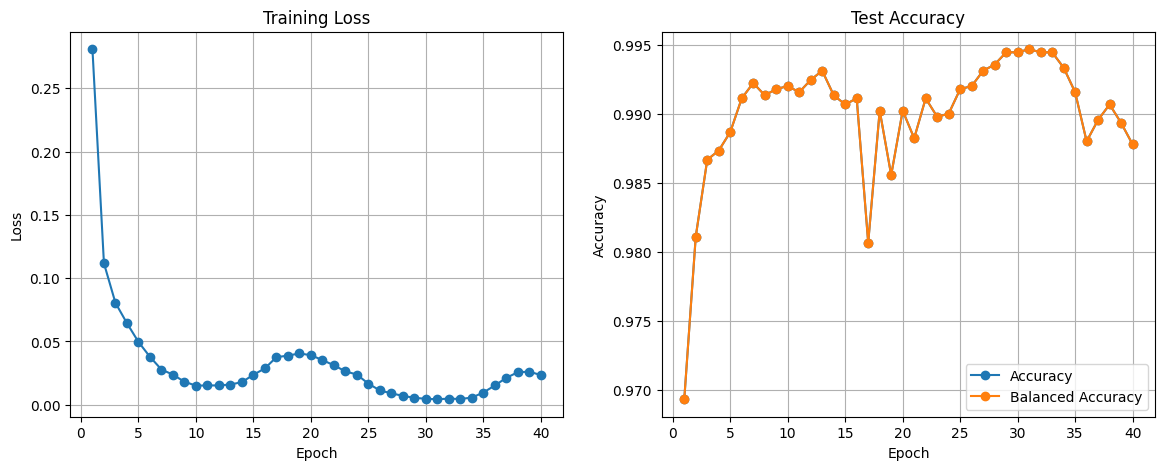

In [16]:
size = "big"
train_dataset = Dataset(f"train_{size}")
test_dataset = Dataset(f"test_{size}")

model = Model(num_classes=len(np.unique(train_dataset.labels)), studying_try="1B0_big")
model.train(
    train_dataset = train_dataset,
    test_dataset = test_dataset,
    batch_size = 50,
    epochs = 25
)
model.plot_training_history()


### Не перезапускайте данные по обучению ни где не сохранены надо заного запускать обучение

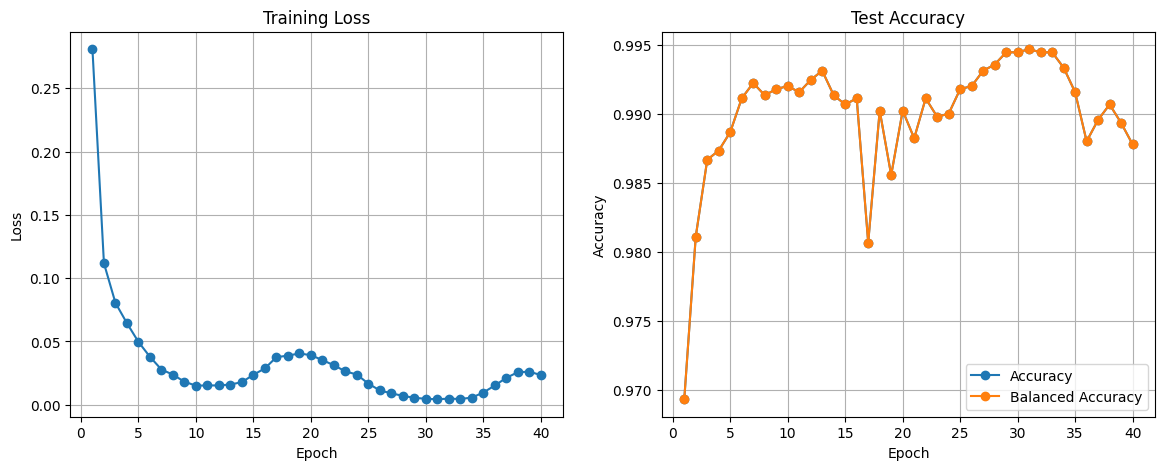

In [ ]:
model.plot_training_history()


### Можно перезапустить

In [61]:
size = "big"
test_dataset = Dataset(f"test_{size}")
model = Model(num_classes=len(np.unique(train_dataset.labels)), studying_try="1B0_small")
model.load("https://drive.google.com/uc?id=1VWyDy3XS2WDboNet5gRCalQMUOKDZ98d")
model.calculate_metrics_on_train(test_dataset=test_dataset)

Файл test_big.npz уже существует — пропускаю скачивание.
Loading dataset test_big from npz.
Done. Dataset test_big consists of 4500 images.
cuda


Downloading...
From: https://drive.google.com/uc?id=1VWyDy3XS2WDboNet5gRCalQMUOKDZ98d
To: /home/avgurmordra/Desktop/MSU3/MMOI/1-task/model_weights.pt
100%|██████████| 16.4M/16.4M [00:03<00:00, 4.15MB/s]


Test on test dataset


100%|██████████| 4500/4500 [00:41<00:00, 109.74it/s]

metrics for testing:
	 accuracy 0.9947:
	 balanced accuracy 0.9947:


(0.9946666666666667, 0.9946666666666667)

### Тут логарифмическая шкала при линейной пятна не видны

100%|██████████| 4500/4500 [00:41<00:00, 107.92it/s]


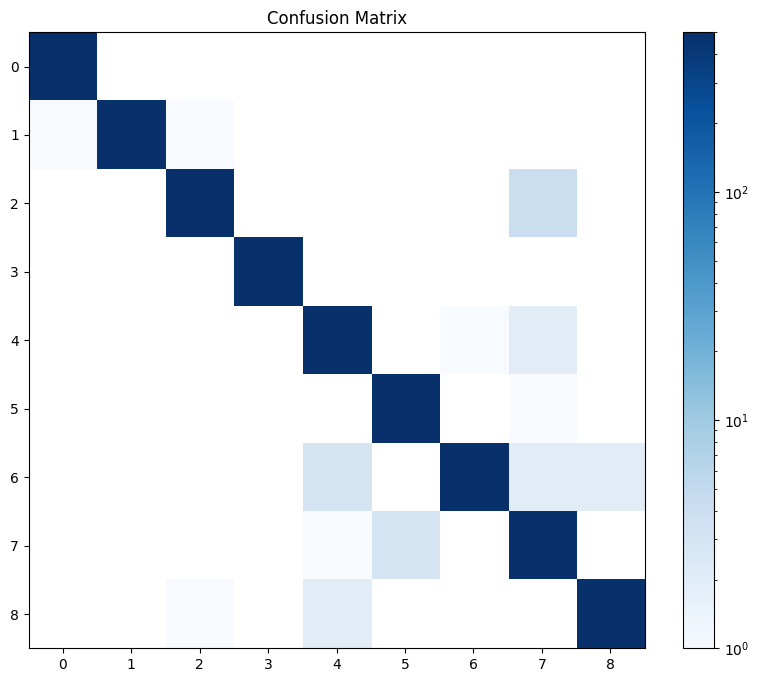

In [59]:
model.plot_matrix(test_dataset=test_dataset)

---
### Класс Model

Класс, хранящий в себе всю информацию о модели.

Вам необходимо реализовать методы save, load для сохранения и заргрузки модели. Особенно актуально это будет во время тестирования на дополнительных наборах данных.

> *Пожалуйста, убедитесь, что сохранение и загрузка модели работает корректно. Для этого обучите модель, протестируйте, сохраните ее в файл, перезапустите среду выполнения, загрузите обученную модель из файла, вновь протестируйте ее на тестовой выборке и убедитесь в том, что получаемые метрики совпадают с полученными для тестовой выбрки ранее.*


Также, Вы можете реализовать дополнительные функции, такие как:
1. валидацию модели на части обучающей выборки;
2. использование кроссвалидации;
3. автоматическое сохранение модели при обучении;
4. загрузку модели с какой-то конкретной итерации обучения (если используется итеративное обучение);
5. вывод различных показателей в процессе обучения (например, значение функции потерь на каждой эпохе);
6. построение графиков, визуализирующих процесс обучения (например, график зависимости функции потерь от номера эпохи обучения);
7. автоматическое тестирование на тестовом наборе/наборах данных после каждой эпохи обучения (при использовании итеративного обучения);
8. автоматический выбор гиперпараметров модели во время обучения;
9. сохранение и визуализацию результатов тестирования;
10. Использование аугментации и других способов синтетического расширения набора данных (дополнительным плюсом будет обоснование необходимости и обоснование выбора конкретных типов аугментации)
11. и т.д.

Полный список опций и дополнений приведен в презентации с описанием задания.

При реализации дополнительных функций допускается добавление параметров в существующие методы и добавление новых методов в класс модели.

In [ ]:
class Model:

    def __init__(self):
        # todo
        pass

    def save(self, name: str):
        # todo
        pass
        # example demonstrating saving the model to PROJECT_DIR folder on gdrive with name 'name'
        arr = np.array([1, 2, 3, 4, 5], dtype=np.float32)
        np.savez(f'/content/drive/MyDrive/{name}.npz', data=arr)

    def load(self, name: str):
        # todo
        pass
        # example demonstrating loading the model with name 'name' from gdrive using link
        name_to_id_dict = {
            'best': '1S8bwrVgvtSzadEX2aLlyb3VTlD31UI4R'
        }
        output = f'{name}.npz'
        gdown.download(f'https://drive.google.com/uc?id={name_to_id_dict[name]}', output, quiet=False)
        np_obj = np.load(f'{name}.npz')
        print(np_obj['data'])

    def train(self, dataset: Dataset):
        # you can add some plots for better visualization,
        # you can add model autosaving during training,
        # etc.
        print(f'training started')
        # to-do
        sleep(2)
        print(f'training done')
        pass

    def test_on_dataset(self, dataset: Dataset, limit=None):
        # you can upgrade this code if you want to speed up testing using batches
        predictions = []
        n = dataset.n_files if not limit else int(dataset.n_files * limit)
        for img in tqdm(dataset.images_seq(n), total=n):
            predictions.append(self.test_on_image(img))
        return predictions

    def test_on_image(self, img: np.ndarray):
        # todo: replace this code
        prediction = np.random.randint(9)
        sleep(0.05)
        return prediction


---
### Классификация изображений

Используя введенные выше классы можем перейти уже непосредственно к обучению модели классификации изображений. Пример общего пайплайна решения задачи приведен ниже. Вы можете его расширять и улучшать. В данном примере используются наборы данных 'train_small' и 'test_small'.

In [ ]:
d_train = Dataset('train_small')
d_test = Dataset('test_small')

In [ ]:
model = Model()
if not EVALUATE_ONLY:
    model.train(d_train)
    model.save('best')
else:
    #todo: your link goes here
    model.load('best')

Пример тестирования модели на части набора данных:

In [ ]:
# evaluating model on 10% of test dataset
pred_1 = model.test_on_dataset(d_test, limit=0.1)
Metrics.print_all(d_test.labels[:len(pred_1)], pred_1, '10% of test')

Пример тестирования модели на полном наборе данных:

In [ ]:
# evaluating model on full test dataset (may take time)
if TEST_ON_LARGE_DATASET:
    pred_2 = model.test_on_dataset(d_test)
    Metrics.print_all(d_test.labels, pred_2, 'test')

Результат работы пайплайна обучения и тестирования выше тоже будет оцениваться. Поэтому не забудьте присылать на проверку ноутбук с выполнеными ячейками кода с демонстрациями метрик обучения, графиками и т.п. В этом пайплайне Вам необходимо продемонстрировать работу всех реализованных дополнений, улучшений и т.п.

<font color="red">
Настоятельно рекомендуется после получения пайплайна с полными результатами обучения экспортировать ноутбук в pdf (файл -> печать) и прислать этот pdf вместе с самим ноутбуком.
</font>

### Тестирование модели на других наборах данных

Ваша модель должна поддерживать тестирование на других наборах данных. Для удобства, Вам предоставляется набор данных test_tiny, который представляет собой малую часть (2% изображений) набора test. Ниже приведен фрагмент кода, который будет осуществлять тестирование для оценивания Вашей модели на дополнительных тестовых наборах данных.

<font color="red">
Прежде чем отсылать задание на проверку, убедитесь в работоспособности фрагмента кода ниже.
</font>

In [ ]:
final_model = Model()
final_model.load('best')
d_test_tiny = Dataset('test_tiny')
pred = final_model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred, 'test-tiny')

Отмонтировать Google Drive.

In [ ]:
drive.flush_and_unmount()

---
# Дополнительные "полезности"

Ниже приведены примеры использования различных функций и библиотек, которые могут быть полезны при выполнении данного практического задания.

### Измерение времени работы кода

Измерять время работы какой-либо функции можно легко и непринужденно при помощи функции timeit из соответствующего модуля:

In [ ]:
import timeit

def factorial(n):
    res = 1
    for i in range(1, n + 1):
        res *= i
    return res


def f():
    return factorial(n=1000)

n_runs = 128
print(f'Function f is caluclated {n_runs} times in {timeit.timeit(f, number=n_runs)}s.')

### Scikit-learn

Для использования "классических" алгоритмов машинного обучения рекомендуется использовать библиотеку scikit-learn (https://scikit-learn.org/stable/). Пример классификации изображений цифр из набора данных MNIST при помощи классификатора SVM:

In [ ]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
_, axes = plt.subplots(2, 4)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes[0, :], images_and_labels[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)

# Now predict the value of the digit on the second half:
predicted = classifier.predict(X_test)

images_and_predictions = list(zip(digits.images[n_samples // 2:], predicted))
for ax, (image, prediction) in zip(axes[1, :], images_and_predictions[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Prediction: %i' % prediction)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, predicted)))

# Матрица ошибок + визуализация в новом API
cm = metrics.confusion_matrix(y_test, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classifier.classes_)

fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax)
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()

### Scikit-image

Реализовывать различные операции для работы с изображениями можно как самостоятельно, работая с массивами numpy, так и используя специализированные библиотеки, например, scikit-image (https://scikit-image.org/). Ниже приведен пример использования Canny edge detector.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature


# Generate noisy image of a square
im = np.zeros((128, 128))
im[32:-32, 32:-32] = 1

im = ndi.rotate(im, 15, mode='constant')
im = ndi.gaussian_filter(im, 4)
im += 0.2 * np.random.random(im.shape)

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma=3)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

### Tensorflow 2

Для создания и обучения нейросетевых моделей можно использовать фреймворк глубокого обучения Tensorflow 2. Ниже приведен пример простейшей нейроной сети, использующейся для классификации изображений из набора данных MNIST.

In [ ]:
# Install TensorFlow

import tensorflow as tf

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)

model.evaluate(x_test,  y_test, verbose=2)

<font color="red">
Для эффективной работы с моделями глубокого обучения убедитесь в том, что в текущей среде Google Colab используется аппаратный ускоритель GPU или TPU. Для смены среды выберите "среда выполнения" -> "сменить среду выполнения".
</font>

Большое количество туториалов и примеров с кодом на Tensorflow 2 можно найти на официальном сайте https://www.tensorflow.org/tutorials?hl=ru.

Также, Вам может понадобиться написать собственный генератор данных для Tensorflow 2. Скорее всего он будет достаточно простым, и его легко можно будет реализовать, используя официальную документацию TensorFlow 2. Но, на всякий случай (если не удлось сразу разобраться или хочется вникнуть в тему более глубоко), можете посмотреть следующий отличный туториал: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.

### PyTorch

In [ ]:
# ============================================================
# Дополнительно: мини-демо PyTorch
# ============================================================
# Ранний выход, если PyTorch/обёртка недоступны
try:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch.utils.data import DataLoader
except ImportError:
    print("PyTorch не установлен — демо пропущено.")
    import sys
    raise SystemExit

if "HistologyTorchDataset" not in globals() or HistologyTorchDataset is None:
    print("HistologyTorchDataset недоступна — демо пропущено.")
    import sys
    raise SystemExit


# --- Данные: tiny-наборы, чтобы выполнялось быстро ---
base_train = Dataset('train_tiny')
base_test  = Dataset('test_tiny')

train_ds = HistologyTorchDataset(base_train)           # ToTensor по умолчанию
test_ds  = HistologyTorchDataset(base_test)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False)

# --- Мини-модель: двухслойный CNN + один FC (демонстрация, не решение) ---
class TinyCNN(nn.Module):
    def __init__(self, num_classes=len(TISSUE_CLASSES)):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)  # 224->112->56
        self.fc    = nn.Linear(16 * 56 * 56, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 3, 224, 224] -> [B, 8, 112, 112]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 8, 112, 112] -> [B, 16, 56, 56]
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = TinyCNN(num_classes=len(TISSUE_CLASSES)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# --- Один учебный шаг "обучения" на одном батче ---
model.train()
xb, yb = next(iter(train_loader))
xb = xb.to(device)
yb = yb.to(device, dtype=torch.long)

optimizer.zero_grad()
logits = model(xb)
loss = criterion(logits, yb)
float_loss = float(loss.detach().cpu())
loss.backward()
optimizer.step()

print(f"Loss на одном батче train_tiny: {float_loss:.4f}")

# --- Быстрая проверка на одном батче теста (для формы вывода/метрик) ---
model.eval()
with torch.no_grad():
    xt, yt = next(iter(test_loader))
    xt = xt.to(device)
    logits_t = model(xt).cpu()
    y_pred = logits_t.argmax(dim=1).numpy()
    y_true = yt.numpy()

print("Размерности:", {"y_true": y_true.shape, "y_pred": y_pred.shape})
Metrics.print_all(y_true, y_pred, "_")  # balanced accuracy/accuracy на одном батче для демонстрации

# для полноценного решения требуется собственный тренировочный цикл по эпохам,
# аугментации/нормализация, сохранение/загрузка весов, и тестирование на всём наборе.

### Дополнительные ресурсы по PyTorch

- **Официальные туториалы PyTorch** — https://pytorch.org/tutorials/  
- **“Deep Learning with PyTorch: 60-Minute Blitz”** — https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
- **Transfer Learning for Computer Vision** — https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html  
- **PyTorch Get Started (установка)** — https://pytorch.org/get-started/locally/  
- **Dive into Deep Learning (D2L, глава PyTorch)** — https://d2l.ai/chapter_preliminaries/index.html  
- **Fast.ai — Practical Deep Learning for Coders** — https://course.fast.ai/  
- **Learn PyTorch.io (Zero to Mastery)** — https://www.learnpytorch.io/

### Numba

В некоторых ситуациях, при ручных реализациях графовых алгоритмов, выполнение многократных вложенных циклов for в python можно существенно ускорить, используя JIT-компилятор Numba (https://numba.pydata.org/).
Примеры использования Numba в Google Colab можно найти тут:
1. https://colab.research.google.com/github/cbernet/maldives/blob/master/numba/numba_cuda.ipynb
2. https://colab.research.google.com/github/evaneschneider/parallel-programming/blob/master/COMPASS_gpu_intro.ipynb

> Пожалуйста, если Вы решили использовать Numba для решения этого практического задания, еще раз подумайте, нужно ли это Вам, и есть ли возможность реализовать требуемую функциональность иным способом. Используйте Numba только при реальной необходимости.



### Работа с zip архивами в Google Drive

Запаковка и распаковка zip архивов может пригодиться при сохранении и загрузки Вашей модели. Ниже приведен фрагмент кода, иллюстрирующий помещение нескольких файлов в zip архив с последующим чтением файлов из него. Все действия с директориями, файлами и архивами должны осущетвляться с примонтированным Google Drive.


Создадим 2 изображения, поместим их в директорию tmp внутри PROJECT_DIR, запакуем директорию tmp в архив tmp.zip.

In [ ]:
PROJECT_DIR = "/dev/prak_nn_1/"
arr1 = np.random.rand(100, 100, 3) * 255
arr2 = np.random.rand(100, 100, 3) * 255

img1 = Image.fromarray(arr1.astype('uint8'))
img2 = Image.fromarray(arr2.astype('uint8'))

p = "/content/drive/MyDrive/" + PROJECT_DIR

if not (Path(p) / 'tmp').exists():
    (Path(p) / 'tmp').mkdir()

img1.save(str(Path(p) / 'tmp' / 'img1.png'))
img2.save(str(Path(p) / 'tmp' / 'img2.png'))

%cd $p
!zip -r "tmp.zip" "tmp"

Распакуем архив tmp.zip в директорию tmp2 в PROJECT_DIR. Теперь внутри директории tmp2 содержится директория tmp, внутри которой находятся 2 изображения.

In [ ]:
p = "/content/drive/MyDrive/" + PROJECT_DIR
%cd $p
!unzip -uq "tmp.zip" -d "tmp2"